<a href="https://colab.research.google.com/github/amitsiwach/Time_series_modelling/blob/main/Seasonal_ARIMA_vs_fbprophet_time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pystan==2.18.0.0
!pip install fbprophet

In [2]:
import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/price_data.csv")

In [5]:
df.shape

(743, 8)

In [6]:
df.head()

,Date,interest,vacancy,cpi,price,value,adj_price,adj_value
0,2/2/2008,5.68,10.1,212.174,215000,243109.3812,101331.92570,114580.1942
1,2/9/2008,5.67,10.1,212.687,204250,243109.3812,96033.13790,114303.8273
2,2/16/2008,5.72,10.1,212.687,215000,243109.3812,101087.51360,114303.8273
3,2/23/2008,6.04,10.1,212.687,200000,243109.3812,94034.89635,114303.8273
4,3/1/2008,6.24,10.1,212.687,215000,240739.0886,101087.51360,113189.3762


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       743 non-null    object 
 1   interest   743 non-null    float64
 2   vacancy    743 non-null    float64
 3   cpi        743 non-null    float64
 4   price      743 non-null    int64  
 5   value      743 non-null    float64
 6   adj_price  743 non-null    float64
 7   adj_value  743 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 46.6+ KB


In [8]:
df.describe()

,interest,vacancy,cpi,price,value,adj_price,adj_value
count,743.000000,743.000000,743.000000,743.000000,743.000000,743.000000,743.000000
mean,4.169744,7.887618,240.466335,227368.837147,250092.176570,93606.095136,103156.282570
std,0.808795,1.565285,19.570472,53526.166609,52099.242584,14902.351507,13771.936861
min,2.650000,5.600000,211.398000,145000.000000,178314.238600,63504.854840,78168.510140
25%,3.630000,6.800000,226.597000,185000.000000,212169.931650,82503.074180,94140.325790
50%,4.060000,7.300000,237.477000,215630.000000,233818.632000,91778.073170,101832.058100
75%,4.605000,9.400000,252.759500,259900.000000,283934.856600,102686.177100,112821.697600
max,6.630000,11.100000,296.761000,375000.000000,380135.564800,127001.974500,131111.258100


### Visualizing the Data

In [9]:
df['Week'] = df["Date"]
df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
df.set_index("Date", inplace = True)

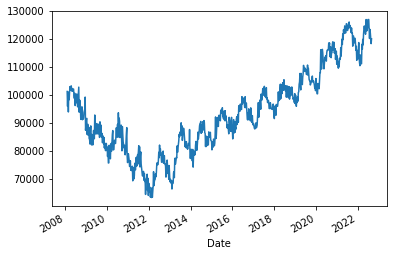

In [10]:
df["adj_price"].plot()

In [11]:
df.columns

Index(['interest', 'vacancy', 'cpi', 'price', 'value', 'adj_price',
       'adj_value', 'Week'],
      dtype='object')

### Forecasting using ARIMA

In [12]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [13]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [14]:
adfuller_test(df['adj_price'])

ADF Test Statistic : -1.2116139703425721
p-value : 0.6685798274664453
#Lags Used : 8
Number of Observations Used : 734
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Differnecing

In [15]:
df['Seasonal First Difference']=df['adj_price']-df['adj_price'].shift(1)

In [16]:
df.head(10)

,interest,vacancy,cpi,price,value,adj_price,adj_value,Week,Seasonal First Difference
Date,,,,,,,,,
2008-02-02,5.68,10.1,212.174,215000,243109.3812,101331.92570,114580.1942,2/2/2008,NaN
2008-02-09,5.67,10.1,212.687,204250,243109.3812,96033.13790,114303.8273,2/9/2008,-5298.78780
2008-02-16,5.72,10.1,212.687,215000,243109.3812,101087.51360,114303.8273,2/16/2008,5054.37570
2008-02-23,6.04,10.1,212.687,200000,243109.3812,94034.89635,114303.8273,2/23/2008,-7052.61725
2008-03-01,6.24,10.1,212.687,215000,240739.0886,101087.51360,113189.3762,3/1/2008,7052.61725
2008-03-08,6.03,10.1,213.448,210000,240739.0886,98384.61827,112785.8254,3/8/2008,-2702.89533
2008-03-15,6.13,10.1,213.448,216000,240739.0886,101195.60740,112785.8254,3/15/2008,2810.98913
2008-03-22,5.87,10.1,213.448,220000,240739.0886,103069.60010,112785.8254,3/22/2008,1873.99270
2008-03-29,5.85,10.1,213.448,217150,240739.0886,101734.38030,112785.8254,3/29/2008,-1335.21980


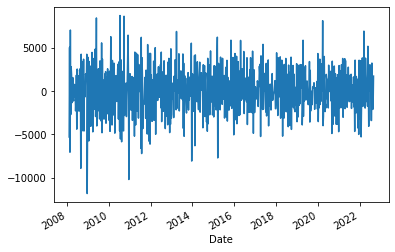

In [17]:
df['Seasonal First Difference'].plot()

In [18]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -8.342021795782859
p-value : 3.1573764240870026e-13
#Lags Used : 7
Number of Observations Used : 734
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### Auto Regressive Model

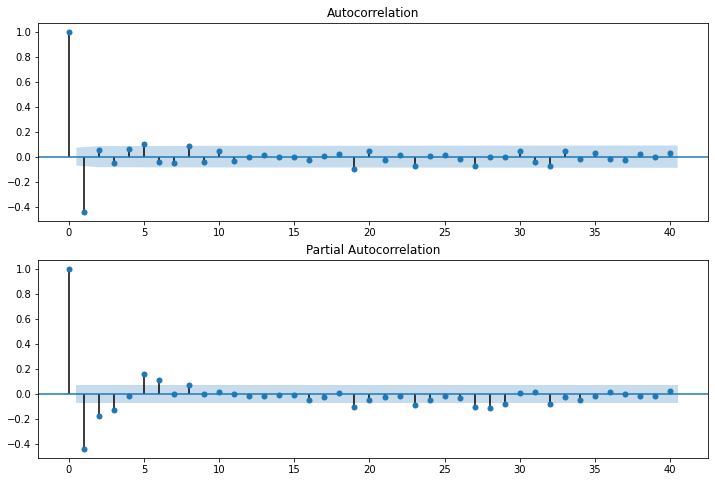

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[2:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[2:],lags=40,ax=ax2)

In [20]:
# For non-seasonal data
## taking p=1,d=1, q=1 for ARIMA model
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(df['adj_price'],order=(1,1,1))
model_fit=model.fit()

model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_price   No. Observations:                  742
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6838.146
Method:                       css-mle   S.D. of innovations           2432.534
Date:                Sun, 30 Oct 2022   AIC                          13684.292
Time:                        13:43:39   BIC                          13702.729
Sample:                             1   HQIC                         13691.400
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                27.6131     47.372      0.583      0.560     -65.234     120.460
ar.L1.D.adj_price    -0.1472      0.062     -2.359      0.018      -0.269      -0.025
ma.L1.D.adj_price    -0.3921      0.055     -7.159      0.000      -0.499      -0.285
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.7946           +0.0000j            6.7946            0.5000
MA.1            2.5504           +0.0000j            2.5504            0.0000
-----------------------------------------------------------------------------
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


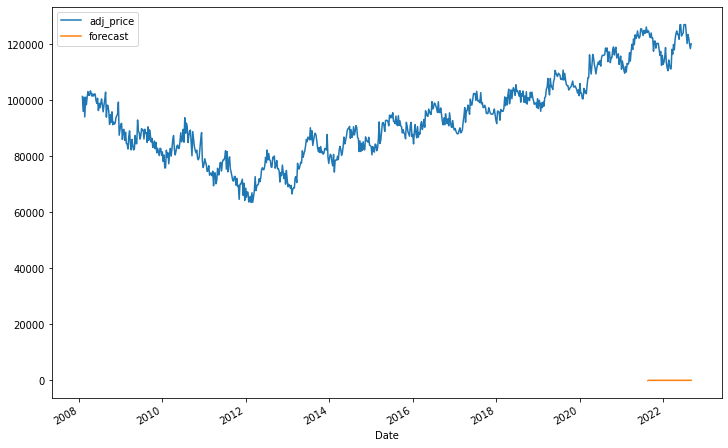

In [21]:
prediction = [None]*690
temp_list = model_fit.predict(start=691,end=743,dynamic=True).values.tolist()
flat_list = [item for item in temp_list]
prediction.extend(flat_list)
df['forecast'] = prediction
df[['adj_price','forecast']].plot(figsize=(12,8))

In [22]:
test_size = 52

df_train = df[:-test_size]
df_test = df[-test_size:]

In [23]:
model=sm.tsa.statespace.SARIMAX(df_train['adj_price'],order=(1, 1, 1),seasonal_order=(1,1,1,52))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


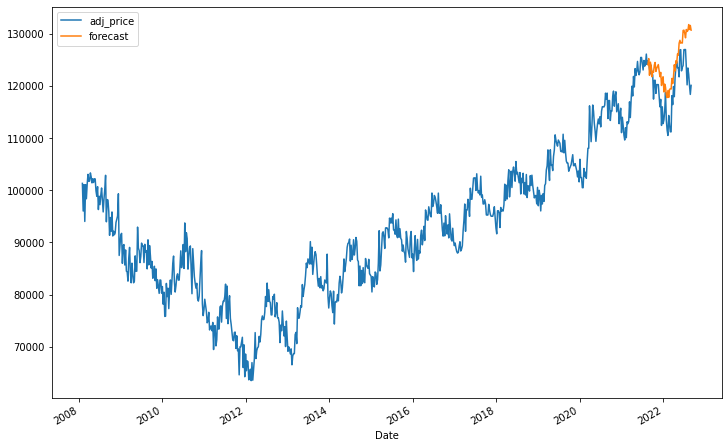

In [24]:
prediction = [None]*690
temp_list = results.predict(start=691,end=743,dynamic=True).values.tolist()
flat_list = [item for item in temp_list]
prediction.extend(flat_list)
df['forecast'] = prediction
df[['adj_price','forecast']].plot(figsize=(12,8))

#### Calculating RMSE & R2

In [25]:
import sklearn.metrics as metrics

In [26]:
arima_mse = metrics.mean_squared_error(df_test['adj_price'], df['forecast'].tail(52))
arima_rmse = np.sqrt(arima_mse)
arima_r2 = metrics.r2_score(df_test['adj_price'], df['forecast'].tail(52))

print("Results of ARIMA_metrics:")
print("RMSE:", arima_rmse)
print("R-Squared:", arima_r2)

Results of ARIMA_metrics:
RMSE: 5662.833324043849
R-Squared: -0.4794609045574112


### Forecasting using fbprophet

In [27]:
df_train = df_train[['Week','adj_price']]
df_train.head()

,Week,adj_price
Date,,
2008-02-02,2/2/2008,101331.92570
2008-02-09,2/9/2008,96033.13790
2008-02-16,2/16/2008,101087.51360
2008-02-23,2/23/2008,94034.89635
2008-03-01,3/1/2008,101087.51360


In [28]:
df_train['Week'] = pd.to_datetime(df_train['Week'],format='%m/%d/%Y')
df_train.columns = ['ds','y']
df_train.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ds,y
Date,,
2008-02-02,2008-02-02,101331.92570
2008-02-09,2008-02-09,96033.13790
2008-02-16,2008-02-16,101087.51360
2008-02-23,2008-02-23,94034.89635
2008-03-01,2008-03-01,101087.51360
2008-03-08,2008-03-08,98384.61827
2008-03-15,2008-03-15,101195.60740
2008-03-22,2008-03-22,103069.60010
2008-03-29,2008-03-29,101734.38030


In [29]:
df_train.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [30]:
# Initialize the Model
model=Prophet()
# Fitting the Model
model.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [32]:
future_dates=model.make_future_dataframe(periods=52, freq="w")

In [33]:
future_dates

,ds
0,2008-02-02
1,2008-02-09
2,2008-02-16
3,2008-02-23
4,2008-03-01
...,...
738,2022-07-17
739,2022-07-24
740,2022-07-31
741,2022-08-07


In [34]:
future_dates.tail(52)

,ds
691,2021-08-22
692,2021-08-29
693,2021-09-05
694,2021-09-12
695,2021-09-19
696,2021-09-26
697,2021-10-03
698,2021-10-10
699,2021-10-17
700,2021-10-24


In [35]:
prediction=model.predict(future_dates)
prediction.head(52)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-02-02,102705.697598,94812.325720,100942.425662,102705.697598,102705.697598,-4870.591330,-4870.591330,-4870.591330,-4870.591330,-4870.591330,-4870.591330,0.0,0.0,0.0,97835.106268
1,2008-02-09,102465.811595,94533.421814,100743.737663,102465.811595,102465.811595,-4947.483475,-4947.483475,-4947.483475,-4947.483475,-4947.483475,-4947.483475,0.0,0.0,0.0,97518.328120
2,2008-02-16,102225.925592,94094.758689,100306.401872,102225.925592,102225.925592,-4953.343912,-4953.343912,-4953.343912,-4953.343912,-4953.343912,-4953.343912,0.0,0.0,0.0,97272.581681
3,2008-02-23,101986.039590,94083.806413,100385.885567,101986.039590,101986.039590,-4850.892738,-4850.892738,-4850.892738,-4850.892738,-4850.892738,-4850.892738,0.0,0.0,0.0,97135.146852
4,2008-03-01,101746.153587,94267.752129,100691.273867,101746.153587,101746.153587,-4443.994646,-4443.994646,-4443.994646,-4443.994646,-4443.994646,-4443.994646,0.0,0.0,0.0,97302.158941
5,2008-03-08,101506.267585,94771.425996,100824.947229,101506.267585,101506.267585,-3558.841234,-3558.841234,-3558.841234,-3558.841234,-3558.841234,-3558.841234,0.0,0.0,0.0,97947.426351
6,2008-03-15,101266.381582,95787.314828,101893.322786,101266.381582,101266.381582,-2315.766840,-2315.766840,-2315.766840,-2315.766840,-2315.766840,-2315.766840,0.0,0.0,0.0,98950.614742
7,2008-03-22,101026.495579,96878.232998,103013.223622,101026.495579,101026.495579,-1145.640700,-1145.640700,-1145.640700,-1145.640700,-1145.640700,-1145.640700,0.0,0.0,0.0,99880.854880
8,2008-03-29,100786.609577,97340.092264,103254.222071,100786.609577,100786.609577,-458.470396,-458.470396,-458.470396,-458.470396,-458.470396,-458.470396,0.0,0.0,0.0,100328.139181
9,2008-04-05,100546.723574,97160.382515,103404.183348,100546.723574,100546.723574,-283.809213,-283.809213,-283.809213,-283.809213,-283.809213,-283.809213,0.0,0.0,0.0,100262.914361


In [36]:
prediction.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [37]:
prediction[['ds','yhat']].tail(52)

,ds,yhat
691,2021-08-22,124594.194881
692,2021-08-29,124324.909378
693,2021-09-05,123660.646534
694,2021-09-12,122855.757498
695,2021-09-19,122177.264887
696,2021-09-26,121743.105112
697,2021-10-03,121531.554956
698,2021-10-10,121463.605843
699,2021-10-17,121447.018752
700,2021-10-24,121399.762576


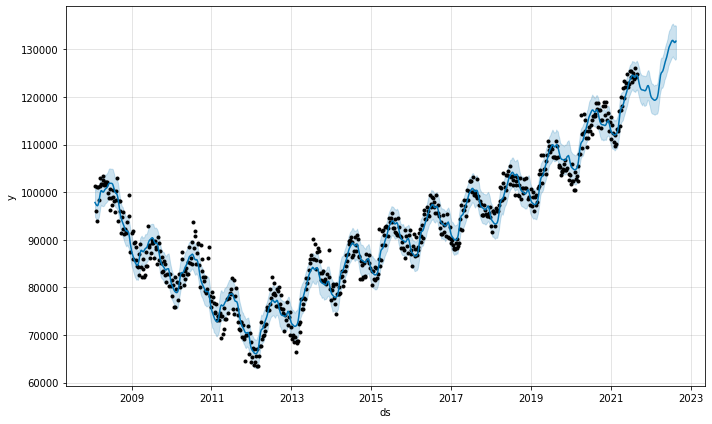

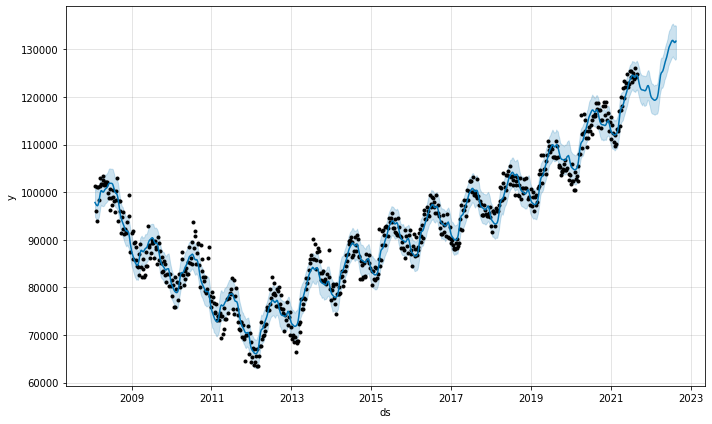

In [38]:
model.plot(prediction)

In [39]:
prediction_df = prediction[['ds','yhat']].tail(52)

#### Calculating RMSE & R2

In [40]:
fbprophet_mse = metrics.mean_squared_error(df['adj_price'][691:743], prediction_df['yhat'])
fbprophet_rmse = np.sqrt(fbprophet_mse)
fbprophet_r2 = metrics.r2_score(df['adj_price'][691:743], prediction_df['yhat'])

print("Results of fbprophet_metrics:")
print("RMSE:", fbprophet_rmse)
print("R-Squared:", fbprophet_r2)

Results of fbprophet_metrics:
RMSE: 5897.283469596595
R-Squared: -0.6045008177721822


##### Based on the RMSE & R2 of both the models, we get that ARIMA model predictions are better than fbprophet model. Hence, we will use ARIMA model for prediction

## Final Prediction from BOTH models

In [41]:
from pandas.tseries.offsets import DateOffset
df['Week'] = pd.to_datetime(df['Week'],format='%m/%d/%Y')
future_dates = []
future_dates.append(df["Week"].iloc[-1])

for i in range(0,52):
  future_dates.append(future_dates[-1] + pd.offsets.Week())

In [42]:
future_dataset_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_dataset_df.tail()

,interest,vacancy,cpi,price,value,adj_price,adj_value,Week,Seasonal First Difference,forecast
2023-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
future_dataset_df.shape

(52, 10)

### Final **ARIMA** Prediction

In [44]:
model=sm.tsa.statespace.SARIMAX(df['adj_price'],order=(1, 1, 1),seasonal_order=(1,1,1,52))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [45]:
predicted_values = results.predict(start = 743, end = 794, dynamic= True)
future_dataset_df['forecast_ARIMA'] = predicted_values.values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


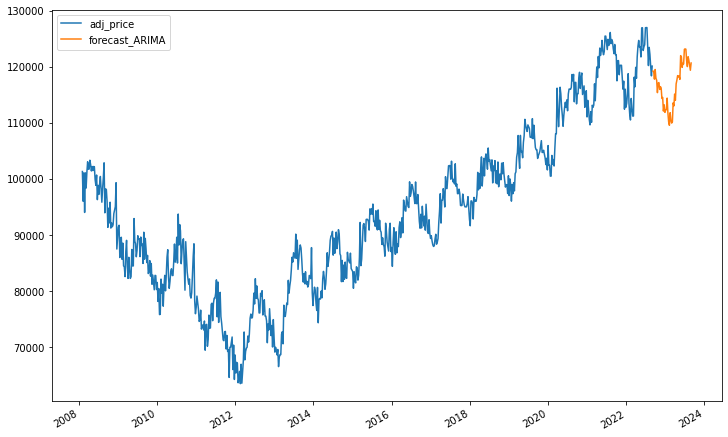

In [46]:
df["forecast_ARIMA"] = None
future_df=pd.concat([df,future_dataset_df])
future_df[['adj_price', 'forecast_ARIMA']].plot(figsize=(12, 8))

In [47]:
future_df['forecast_ARIMA'].tail(52)

2022-09-10    119245.105785
2022-09-17    119195.934264
2022-09-24    117806.779914
2022-10-01    119530.089784
2022-10-08    117972.955287
2022-10-15    117604.339638
2022-10-22    115396.988229
2022-10-29    117091.624788
2022-11-05    117197.371875
2022-11-12    115969.261866
2022-11-19    116469.617930
2022-11-26    116224.657179
2022-12-03    114363.267011
2022-12-10    114543.377912
2022-12-17    112107.218035
2022-12-24    113228.750769
2022-12-31    111879.881900
2023-01-07    112242.577664
2023-01-14    112425.065866
2023-01-21    114424.223620
2023-01-28    111781.807162
2023-02-04    110196.650171
2023-02-11    109574.683523
2023-02-18    111821.591442
2023-02-25    110513.301549
2023-03-04    109970.034012
2023-03-11    110200.027851
2023-03-18    113581.282655
2023-03-25    113033.584009
2023-04-01    115141.761479
2023-04-08    114032.517696
2023-04-15    116961.727986
2023-04-22    117629.282052
2023-04-29    118433.434775
2023-05-06    118213.526943
2023-05-13    118373

Final fbprophet Prediction

In [48]:
df_for_fbprophet = df[['Week','adj_price']]
df_for_fbprophet.head()

,Week,adj_price
Date,,
2008-02-02,2008-02-02,101331.92570
2008-02-09,2008-02-09,96033.13790
2008-02-16,2008-02-16,101087.51360
2008-02-23,2008-02-23,94034.89635
2008-03-01,2008-03-01,101087.51360


In [49]:
df_for_fbprophet['Week'] = pd.to_datetime(df_for_fbprophet['Week'],format='%m/%d/%Y')
df_for_fbprophet.columns = ['ds','y']
df_for_fbprophet.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ds,y
Date,,
2008-02-02,2008-02-02,101331.92570
2008-02-09,2008-02-09,96033.13790
2008-02-16,2008-02-16,101087.51360
2008-02-23,2008-02-23,94034.89635
2008-03-01,2008-03-01,101087.51360
2008-03-08,2008-03-08,98384.61827
2008-03-15,2008-03-15,101195.60740
2008-03-22,2008-03-22,103069.60010
2008-03-29,2008-03-29,101734.38030


In [50]:
df_for_fbprophet.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [51]:
# Initialize the Model
model=Prophet()
# Fitting the Model
model.fit(df_for_fbprophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [53]:
future_dates=model.make_future_dataframe(periods=52, freq="w")

In [54]:
future_dates

,ds
0,2008-02-02
1,2008-02-09
2,2008-02-16
3,2008-02-23
4,2008-03-01
...,...
790,2023-07-30
791,2023-08-06
792,2023-08-13
793,2023-08-20


In [55]:
future_dates.tail(52)

,ds
743,2022-09-04
744,2022-09-11
745,2022-09-18
746,2022-09-25
747,2022-10-02
748,2022-10-09
749,2022-10-16
750,2022-10-23
751,2022-10-30
752,2022-11-06


In [56]:
prediction=model.predict(future_dates)
prediction.head(52)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-02-02,101870.170039,93541.144265,100410.836497,101870.170039,101870.170039,-4968.905667,-4968.905667,-4968.905667,-4968.905667,-4968.905667,-4968.905667,0.0,0.0,0.0,96901.264372
1,2008-02-09,101658.512988,93198.426943,99845.639573,101658.512988,101658.512988,-5067.203003,-5067.203003,-5067.203003,-5067.203003,-5067.203003,-5067.203003,0.0,0.0,0.0,96591.309985
2,2008-02-16,101446.855936,93048.132593,99613.168224,101446.855936,101446.855936,-5109.694425,-5109.694425,-5109.694425,-5109.694425,-5109.694425,-5109.694425,0.0,0.0,0.0,96337.161511
3,2008-02-23,101235.198885,92549.771943,99339.124873,101235.198885,101235.198885,-5059.747143,-5059.747143,-5059.747143,-5059.747143,-5059.747143,-5059.747143,0.0,0.0,0.0,96175.451742
4,2008-03-01,101023.541833,92976.445970,99650.398892,101023.541833,101023.541833,-4679.906706,-4679.906706,-4679.906706,-4679.906706,-4679.906706,-4679.906706,0.0,0.0,0.0,96343.635127
5,2008-03-08,100811.884782,93811.328551,100224.637570,100811.884782,100811.884782,-3768.125356,-3768.125356,-3768.125356,-3768.125356,-3768.125356,-3768.125356,0.0,0.0,0.0,97043.759426
6,2008-03-15,100600.227730,94939.298909,101488.943113,100600.227730,100600.227730,-2471.122854,-2471.122854,-2471.122854,-2471.122854,-2471.122854,-2471.122854,0.0,0.0,0.0,98129.104876
7,2008-03-22,100388.570679,95558.747949,102502.385691,100388.570679,100388.570679,-1263.969555,-1263.969555,-1263.969555,-1263.969555,-1263.969555,-1263.969555,0.0,0.0,0.0,99124.601124
8,2008-03-29,100176.913627,96426.120079,103294.903585,100176.913627,100176.913627,-552.103128,-552.103128,-552.103128,-552.103128,-552.103128,-552.103128,0.0,0.0,0.0,99624.810500
9,2008-04-05,99965.256576,96425.388860,103001.632433,99965.256576,99965.256576,-313.524997,-313.524997,-313.524997,-313.524997,-313.524997,-313.524997,0.0,0.0,0.0,99651.731579


In [57]:
prediction.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [58]:
prediction[['ds','yhat']].tail(52)

,ds,yhat
743,2022-09-04,126566.927801
744,2022-09-11,126013.212147
745,2022-09-18,125502.877119
746,2022-09-25,125028.426422
747,2022-10-02,124612.843875
748,2022-10-09,124353.175299
749,2022-10-16,124288.115438
750,2022-10-23,124297.062344
751,2022-10-30,124222.712935
752,2022-11-06,124090.871974


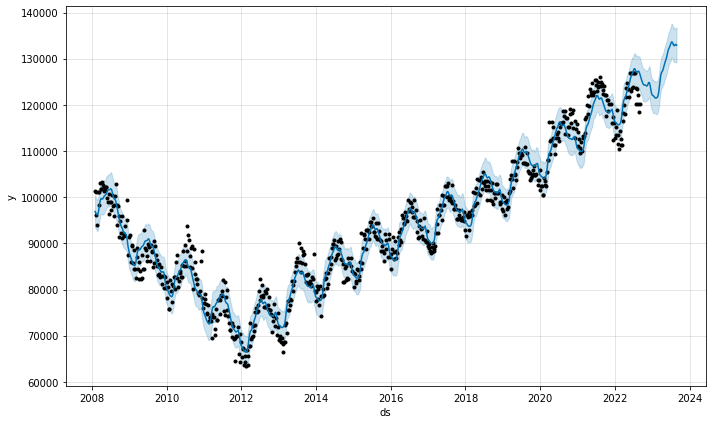

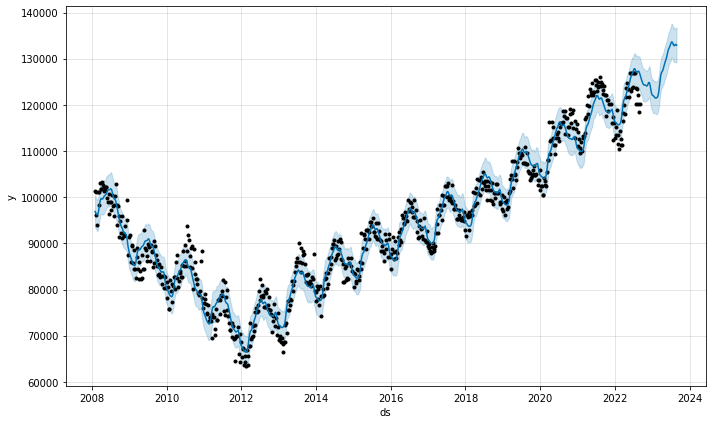

In [59]:
model.plot(prediction)

In [60]:
prediction_df = prediction[['ds','yhat']].tail(52)

In [61]:
future_df['forecast_fbprophet'] = None
future_df['forecast_fbprophet'].iloc[743:795] = prediction_df['yhat']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Final Prediction by **Both** models

In [62]:
future_df[['forecast_ARIMA','forecast_fbprophet']].tail(52)

,forecast_ARIMA,forecast_fbprophet
2022-09-10,119245.105785,126566.927801
2022-09-17,119195.934264,126013.212147
2022-09-24,117806.779914,125502.877119
2022-10-01,119530.089784,125028.426422
2022-10-08,117972.955287,124612.843875
2022-10-15,117604.339638,124353.175299
2022-10-22,115396.988229,124288.115438
2022-10-29,117091.624788,124297.062344
2022-11-05,117197.371875,124222.712935
2022-11-12,115969.261866,124090.871974


Which month is best for real estate investment for the next 6-12 months?

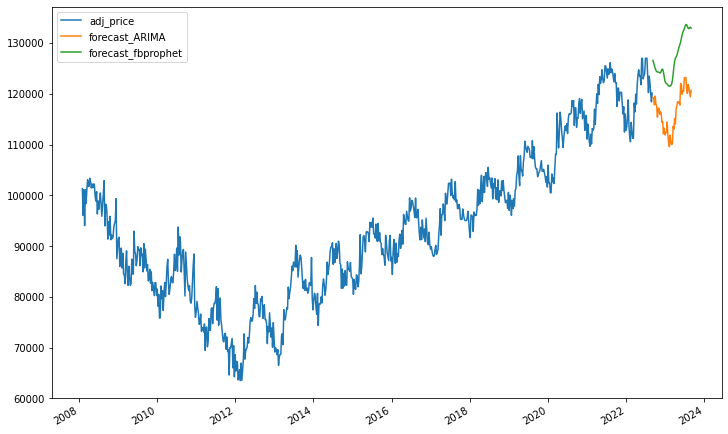

In [63]:
future_df[['adj_price', 'forecast_ARIMA','forecast_fbprophet']].plot(figsize=(12, 8))

Which month is best for real estate investment for the next 6-12 months?

In [64]:
#Based on ARIMA model prediction

future_df[future_df['forecast_ARIMA']==min(future_df['forecast_ARIMA'].tail(52))][['forecast_ARIMA']]

,forecast_ARIMA
2023-02-11,109574.683523


In [65]:
#Based on fbprophet model prediction

future_df[future_df['forecast_fbprophet']==min(future_df['forecast_fbprophet'].tail(52))][['forecast_fbprophet']]

,forecast_fbprophet
2023-02-11,121465.077364
